# Data pre-processing

Importing libraries:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Defining constants:

In [2]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
DATASET_DIR='./dataset/'

Defining a function to load the dataset:

In [3]:
def load_dataset_from_csv(dir):
    X = []
    y = []
    ids = []

    for root, dirs, files in os.walk(dir):
        dirs.sort()
        files = sorted(files)
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                if df['time'].iloc[0] != 0.002:
                    print(f"{file_path} will be discarded because it has a starting time value of {df['time'].iloc[0]} (expected 0.002)")
                    continue
                if not df['time'].is_monotonic_increasing:
                    print(f"{file_path} will be discarded because 'time' is not ordered") # never printed 
                    continue
                features = df[['fsr1','fsr2','cs1','cs2']].values
                label = df['obj'].iloc[0]
                X.append(features)
                y.append(label)
                ids.append(file[:-4])

    X = np.array(X)
    y = np.array(y)
    ids = np.array(ids)

    return X, y, ids

Loading the dataset:

In [4]:
X, y, ids = load_dataset_from_csv(DATASET_DIR)

./dataset/ball/ball_22.csv will be discarded because it has a starting time value of 29.702 (expected 0.002)
./dataset/bigball/bigball_01.csv will be discarded because it has a starting time value of 4.802 (expected 0.002)
./dataset/bigball/bigball_05.csv will be discarded because it has a starting time value of 20.302 (expected 0.002)
./dataset/box/box_08.csv will be discarded because it has a starting time value of 4.852 (expected 0.002)
./dataset/box/box_23.csv will be discarded because it has a starting time value of 16.752 (expected 0.002)
./dataset/box/box_36.csv will be discarded because it has a starting time value of 19.602 (expected 0.002)
./dataset/cube/cube_06.csv will be discarded because it has a starting time value of 22.352 (expected 0.002)
./dataset/cube/cube_07.csv will be discarded because it has a starting time value of 6.452 (expected 0.002)
./dataset/cube/cube_10.csv will be discarded because it has a starting time value of 39.202 (expected 0.002)
./dataset/cube/c

Dataset statistics:

Number of samples: 768
Number of timesteps per sample: 150
Number of features per timestep: 4
Number of classes: 17
Number of samples per class


button            55
smallbutton       54
lemon             48
syringe           48
case              48
cylinder          48
ball              47
smallcube         47
metalbrick        47
jenga             47
labello           47
bigball           46
tomato            46
box               45
cube              44
parallelepiped    40
empty             11
Name: count, dtype: int64

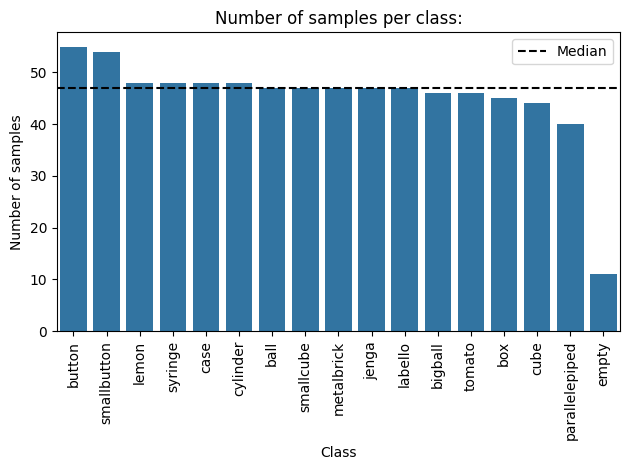

In [5]:
print("Number of samples:", X.shape[0])
print("Number of timesteps per sample:", X.shape[1])
print("Number of features per timestep:", X.shape[2])
print("Number of classes:", len(np.unique(y)))
class_counts = pd.Series(y).value_counts()
print('Number of samples per class')
display(class_counts)
sns.barplot(x=class_counts.index, y=class_counts.values)
median_samples = int(class_counts.median())
plt.axhline(median_samples, color='k', linestyle='--', label='Median')
plt.title('Number of samples per class:')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

Applying random oversampling to the 'empty' class:

In [6]:
empty_indices = np.where(y == 'empty')[0]
n_to_add = median_samples - len(empty_indices)
sampled_indices = np.random.choice(empty_indices, size=n_to_add, replace=True)
X = np.concatenate([X, X[sampled_indices]], axis=0)
y = np.concatenate([y, y[sampled_indices]], axis=0)
ids = np.concatenate([ids, ids[sampled_indices]], axis=0)
class_counts = pd.Series(y).value_counts()
print('Number of samples per class after balancing:')
display(class_counts)

Number of samples per class after balancing:


button            55
smallbutton       54
lemon             48
syringe           48
case              48
cylinder          48
ball              47
smallcube         47
metalbrick        47
jenga             47
labello           47
empty             47
bigball           46
tomato            46
box               45
cube              44
parallelepiped    40
Name: count, dtype: int64

Visualizing the dataset distribution:

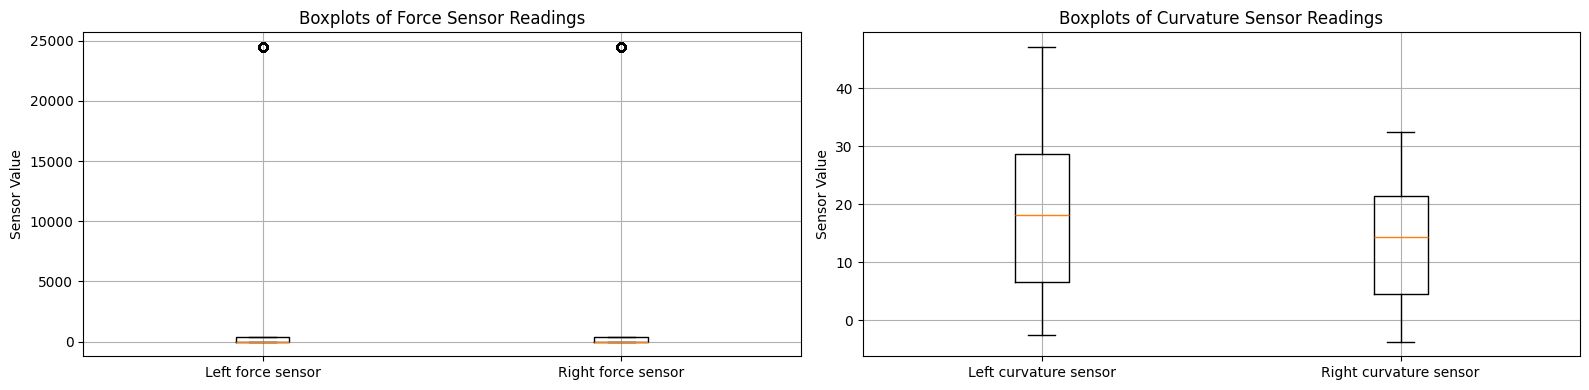

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].boxplot([X[:, :, 0].flatten(),  X[:, :, 1].flatten()], tick_labels=['Left force sensor', 'Right force sensor'])
axs[0].set_title('Boxplots of Force Sensor Readings')
axs[0].set_ylabel('Sensor Value')
axs[0].grid(True)

axs[1].boxplot([X[:, :, 2].flatten(),  X[:, :, 3].flatten()], tick_labels=['Left curvature sensor', 'Right curvature sensor'])
axs[1].set_title('Boxplots of Curvature Sensor Readings')
axs[1].set_ylabel('Sensor Value')
axs[1].grid(True)

plt.tight_layout()

Defining a function to plot the time series of a selected sensor feature for randomly chosen objects in each class:

In [8]:
def plot_random_samples(X, y, obj_ids, feature, num_objs_to_plot):
    if feature == 'fsr1':
        feature_idx = 0
        feature_name = 'Left force sensor'
    elif feature == 'fsr2':
        feature_idx = 1
        feature_name = 'Right force sensor'
    elif feature == 'cs1':
        feature_idx = 2
        feature_name = 'Left curvature sensor'
    elif feature == 'cs2':
        feature_idx = 3
        feature_name = 'Right curvature sensor'
    else:
        raise ValueError("Invalid feature specified. Choose from 'fsr1', 'fsr2', 'cs1', 'cs2'.")
    
    colors = sns.color_palette("hls", num_objs_to_plot)
    _, axs = plt.subplots(len(np.unique(y)), 1, figsize=(20, 3*len(np.unique(y))), sharey=True)
    for i, class_ in enumerate(np.unique(y)):
        objs = np.where(y == class_)[0]
        rng = np.random.default_rng(RANDOM_SEED)
        objs_sub = rng.choice(objs, size=num_objs_to_plot, replace=False)
        for j, obj_idx in enumerate(objs_sub):
            axs[i].plot(X[obj_idx, :, feature_idx], '-o', color=colors[j], markersize=4, label=obj_ids[objs_sub[j]])
        axs[i].set_title(f"{feature_name} - Class '{obj_ids[objs_sub[0]][:-3]}'")
        axs[i].grid()
        axs[i].legend(fontsize='small')
        axs[i].set_ylabel('Sensor Value')
        axs[i].set_xlabel('Time Steps')
        plt.tight_layout()

Plotting the left force sensor time series for 3 random objects per class:

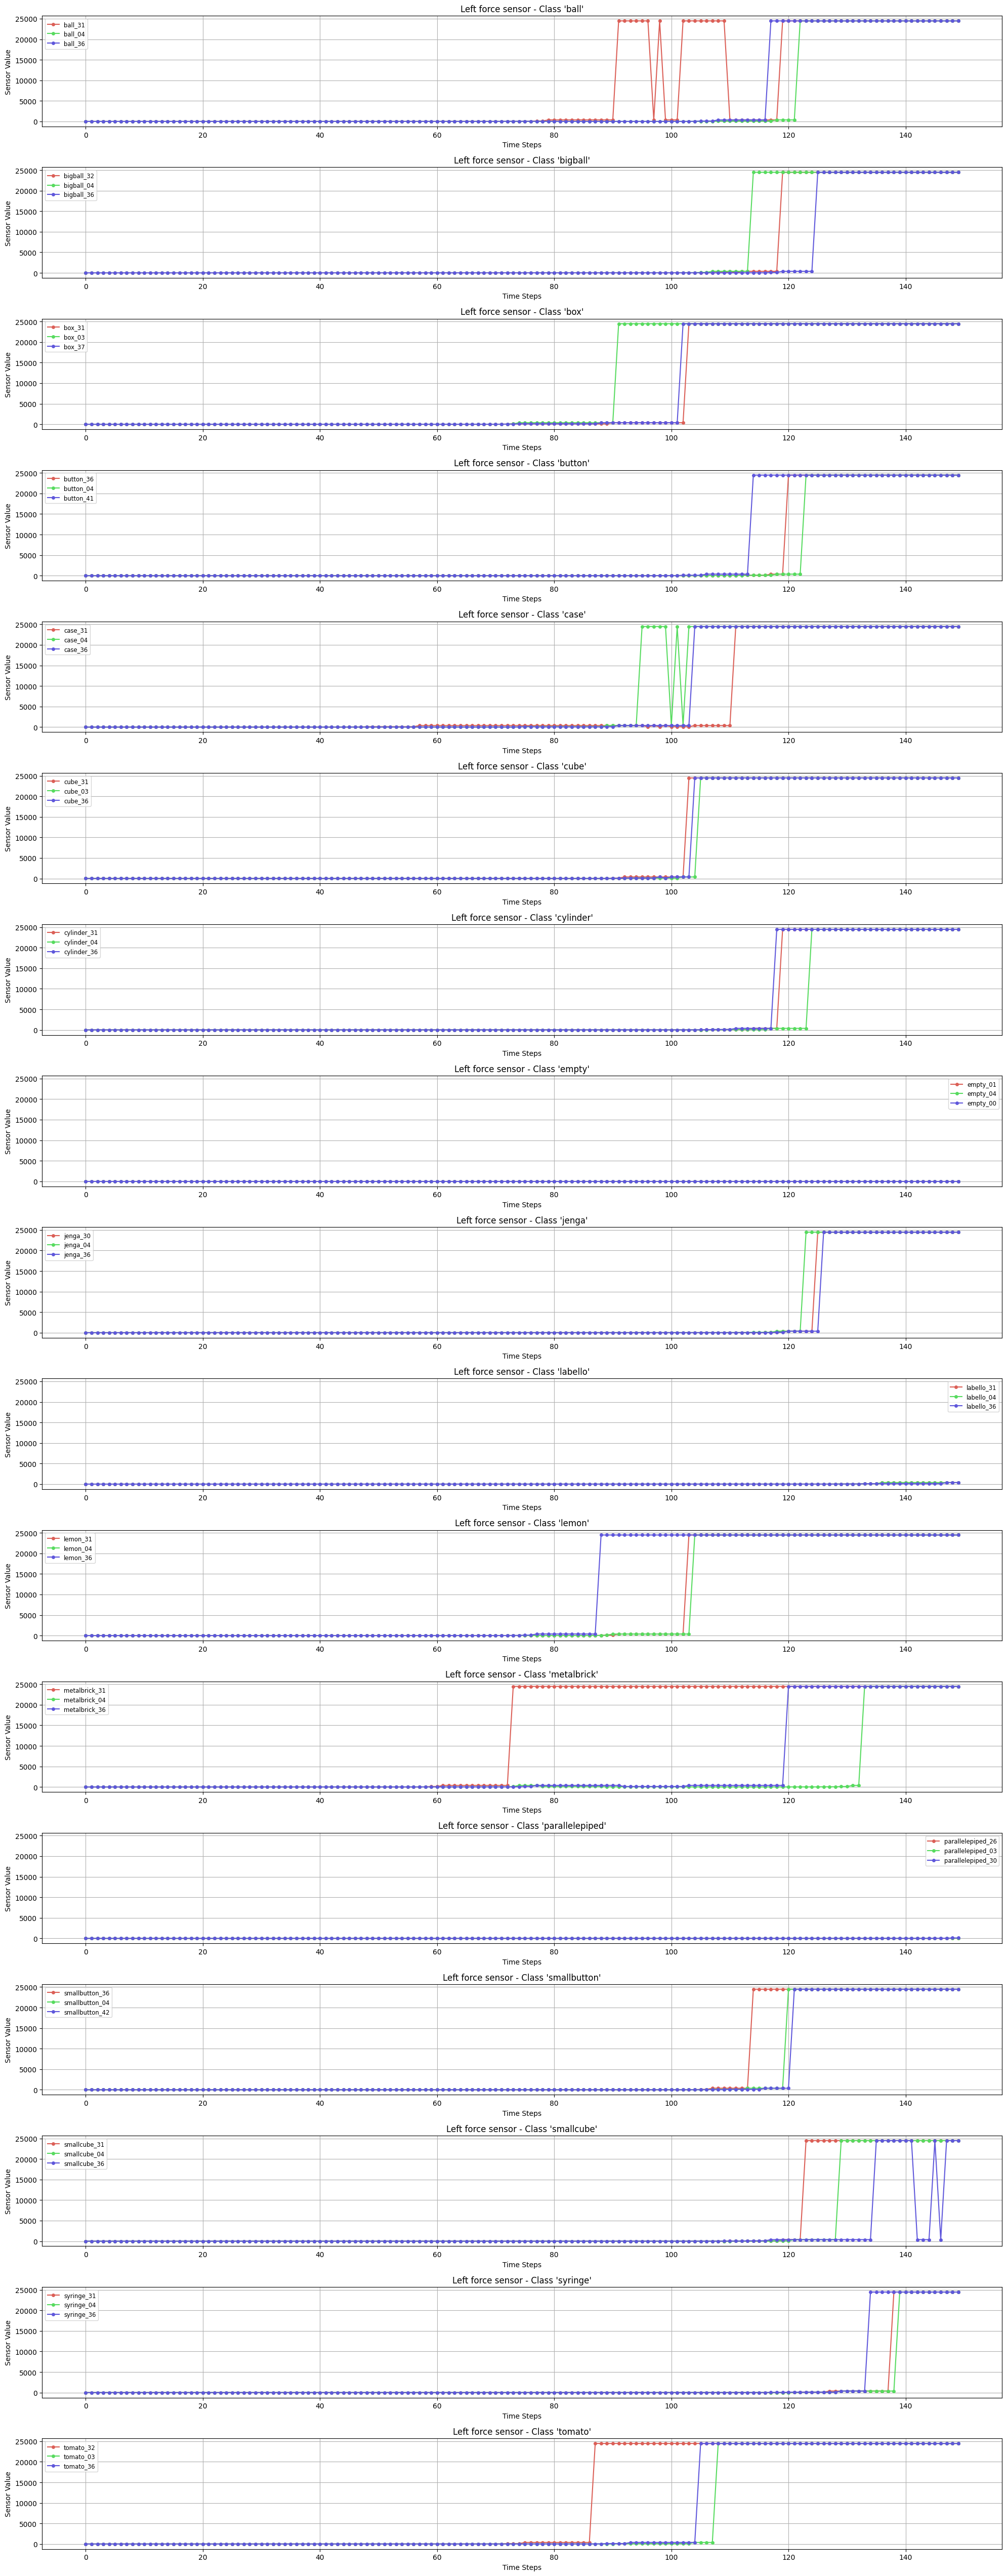

In [9]:
plot_random_samples(X, y, ids, feature='fsr1', num_objs_to_plot=3)

Plotting the right force sensor time series for 3 random objects per class:

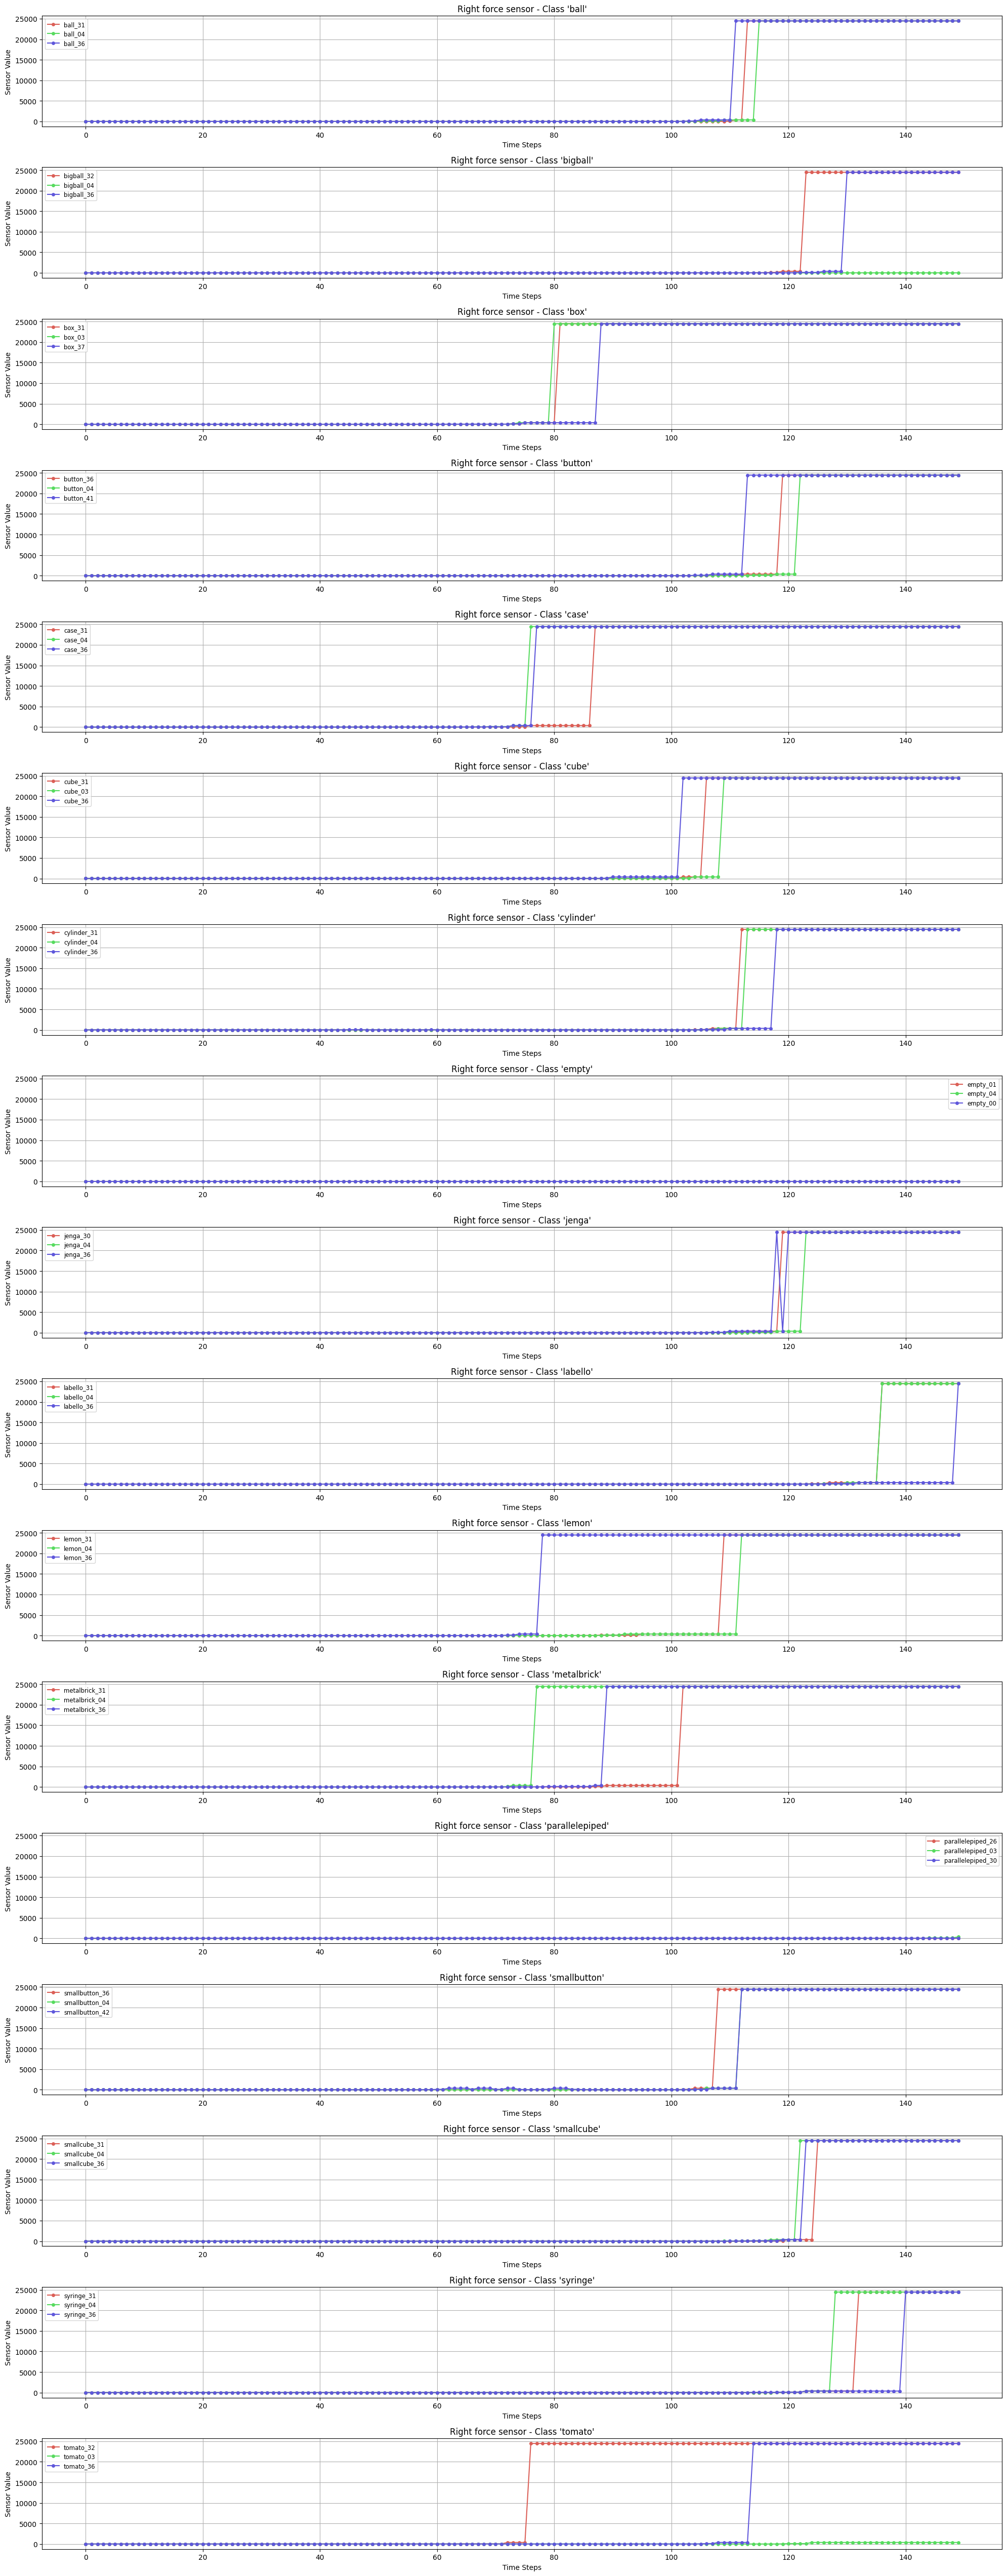

In [10]:
plot_random_samples(X, y, ids, feature='fsr2', num_objs_to_plot=3)

Plotting the left curvature sensor time series for 3 random objects per class:

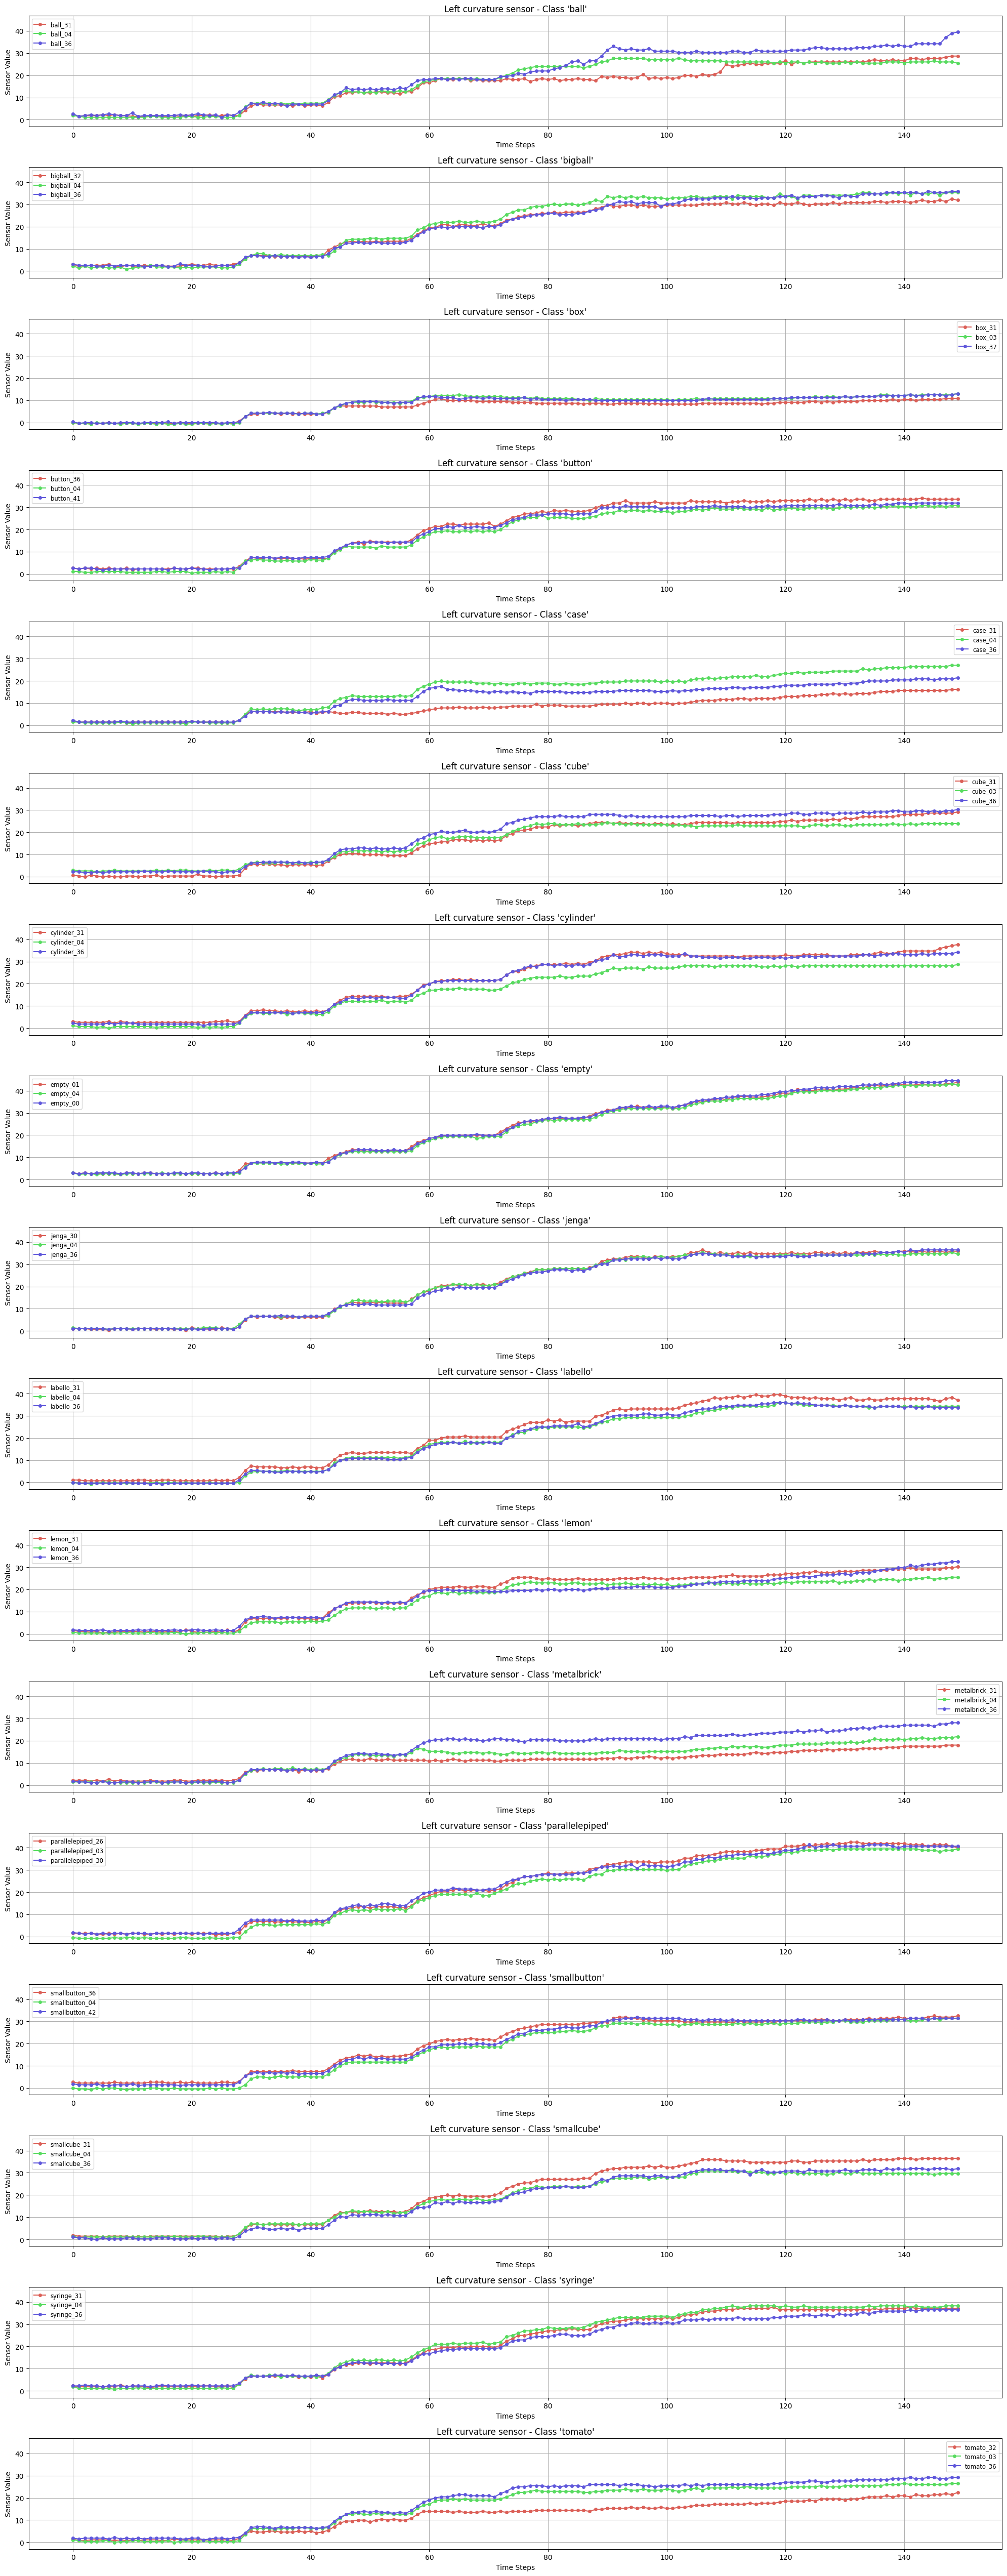

In [11]:
plot_random_samples(X, y, ids, feature='cs1', num_objs_to_plot=3)

Plotting the right curvature sensor time series for 3 random objects per class:

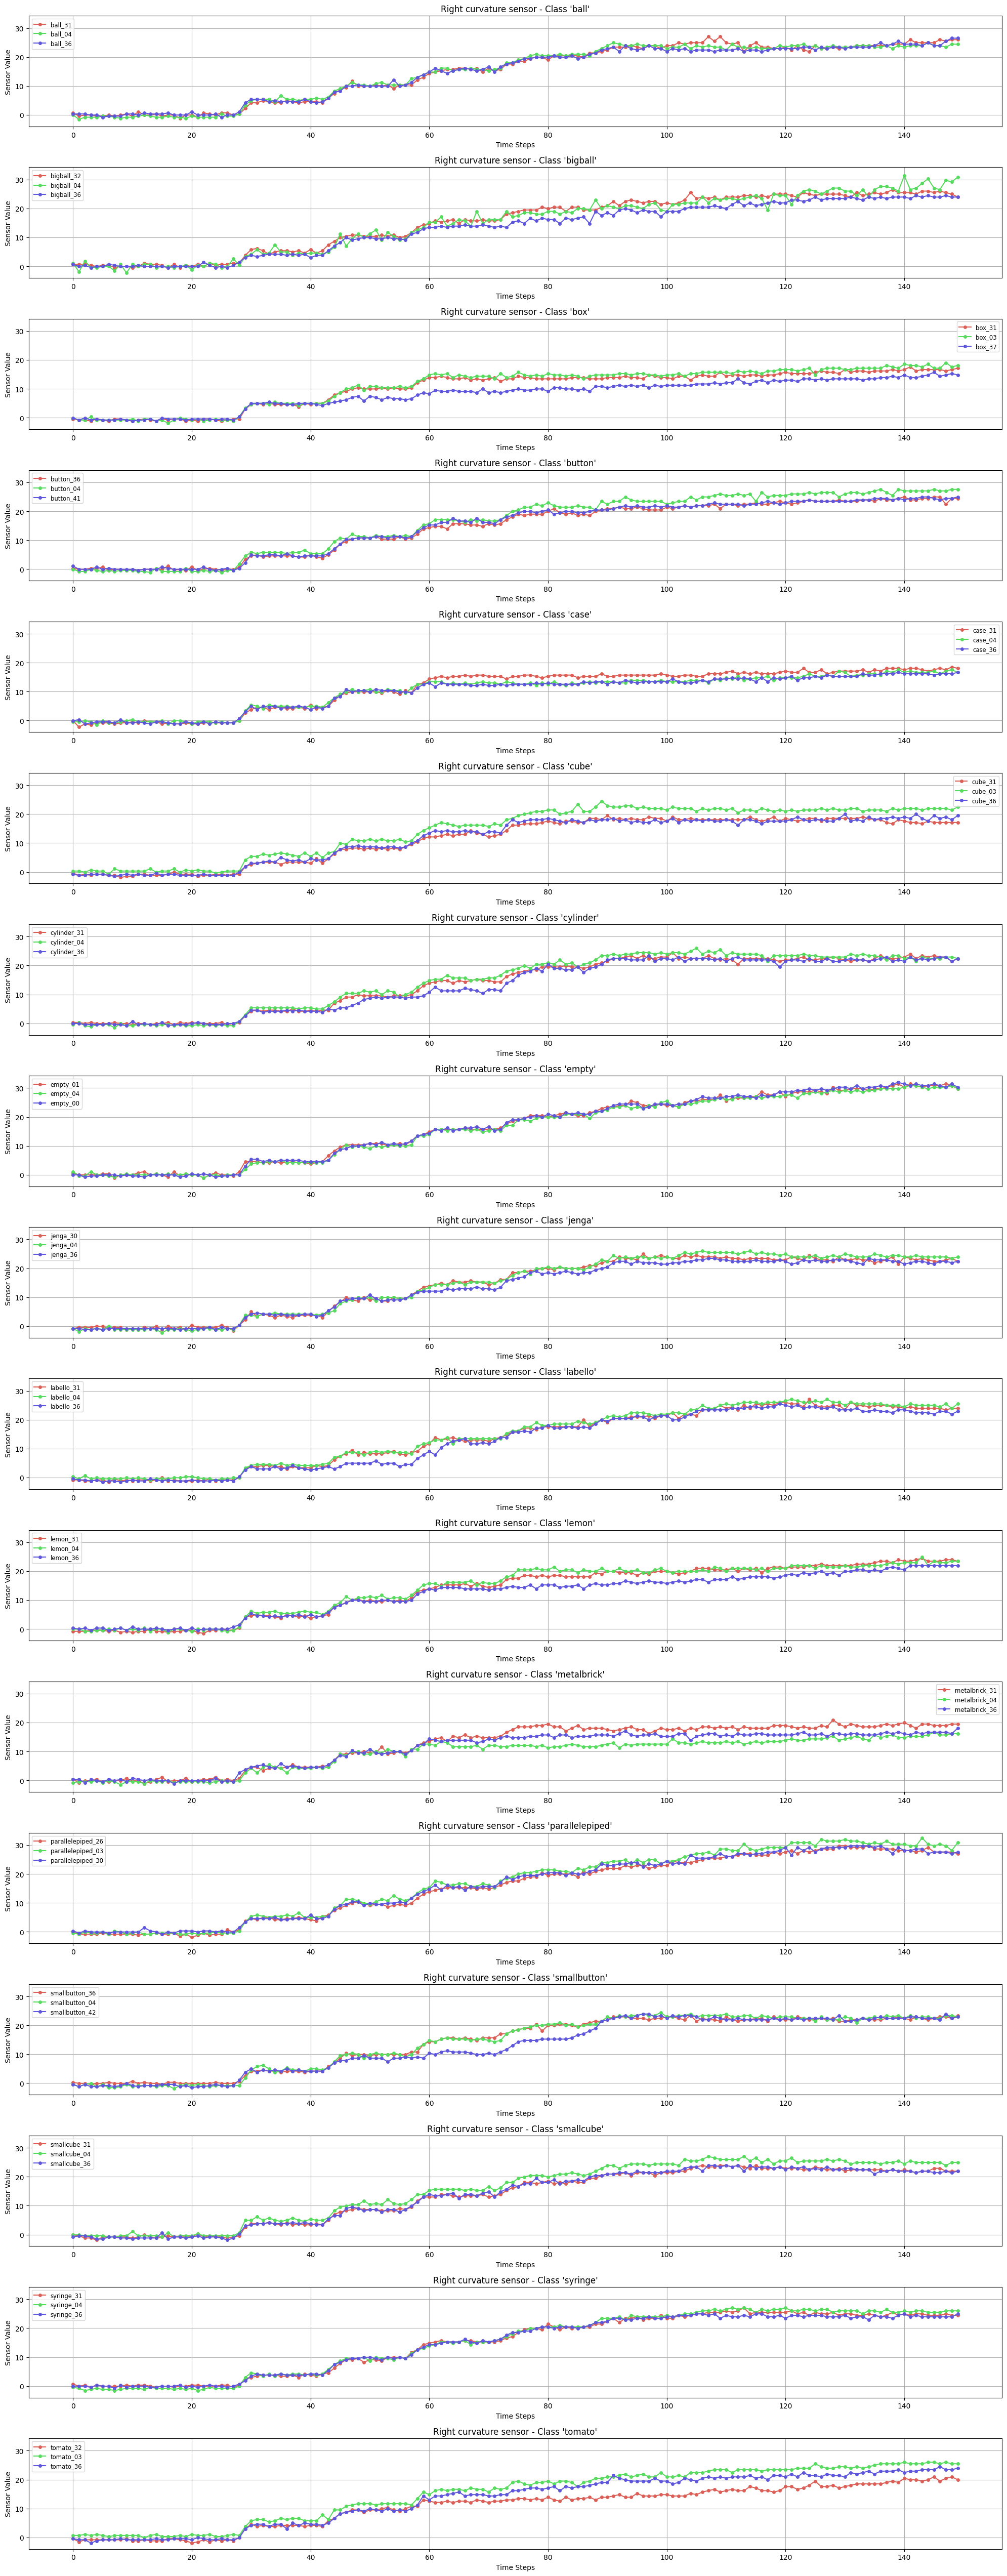

In [12]:
plot_random_samples(X, y, ids, feature='cs2', num_objs_to_plot=3)

Encoding object labels:

In [13]:
le = LabelEncoder()
y = le.fit_transform(y)
y_mapping = le.classes_
print("Unique classes after encoding:\n", np.unique(y))

Unique classes after encoding:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Splitting the dataset into training, validation, and test sets (approximately 80%/10%/10%), with balanced class distributions:

In [14]:
X_train, X_dev, y_train, y_dev, ids_train, ids_dev = train_test_split(
    X, y, ids, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_dev, y_dev, ids_dev, test_size=0.5, random_state=RANDOM_SEED, stratify=y_dev
)
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.2f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.2f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.2f}%)")

Training set size: 643 (79.98%)
Validation set size: 80 (9.95%)
Test set size: 81 (10.07%)


Defining a function to scale the features to the range [0, 1]:

In [15]:
def scale_data(X_train, X_test, X_val=None):
    scaler = MinMaxScaler()

    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler.transform(X_test_reshaped)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)

    if X_val is not None:
        X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
        X_val_scaled = scaler.transform(X_val_reshaped)
        X_val_scaled = X_val_scaled.reshape(X_val.shape)
        return X_train_scaled, X_test_scaled, X_val_scaled
    else:
        return X_train_scaled, X_test_scaled

Scaling the data:

In [16]:
X_train, X_test, X_val = scale_data(X_train, X_test, X_val)

Saving the dataset as a '.npz' file:

In [17]:
X_dev = np.concatenate([X_train, X_val], axis=0)
y_dev = np.concatenate([y_train, y_val], axis=0)
np.savez_compressed(
    os.path.join(DATASET_DIR, 'dataset.npz'),
    X_train=X_train, y_train=y_train, ids_train=ids_train,
    X_val=X_val, y_val=y_val, ids_val=ids_val,
    X_dev=X_dev, y_dev=y_dev, ids_dev=ids_dev,
    X_test=X_test, y_test=y_test, ids_test=ids_test,
    y_mapping=y_mapping
)

Defining functions to split the data for few-shot learning:

In [18]:
def create_base_dataset(X, y, ids, new_classes):
    is_new = np.isin(y, new_classes)
    is_base = ~is_new
    X_base, y_base, ids_base = X[is_base], y[is_base], ids[is_base]
    X_new,  y_new,  ids_new  = X[is_new],  y[is_new],  ids[is_new]

    X_train, X_dev, y_train, y_dev, ids_train, ids_dev = train_test_split(
        X_base, y_base, ids_base, test_size=0.2, random_state=RANDOM_SEED, stratify=y_base
    )
    X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
        X_dev, y_dev, ids_dev, test_size=0.5, random_state=RANDOM_SEED, stratify=y_dev
    )

    X_train_scaled, X_test_scaled, X_val_scaled = scale_data(X_train, X_test, X_val)
    _, X_new_scaled = scale_data(X_train, X_new)
    
    X_dev_scaled = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
    y_dev = np.concatenate([y_train, y_val], axis=0)

    return {
        'X_train': X_train_scaled, 'y_train': y_train, 'ids_train': ids_train,
        'X_val': X_val_scaled, 'y_val': y_val, 'ids_val': ids_val,
        'X_dev': X_dev_scaled, 'y_dev': y_dev, 'ids_dev': ids_dev,
        'X_test': X_test_scaled, 'y_test': y_test, 'ids_test': ids_test,
        'X_new': X_new_scaled, 'y_new': y_new, 'ids_new': ids_new,
    }


def create_few_shot_dataset(X, y, ids, num_shots):
    X_support, y_support, ids_support = [], [], []
    X_query, y_query, ids_query = [], [], []
    for cls in np.unique(y):
        cls_indices = np.where(y == cls)[0]
        if len(cls_indices) < num_shots + 1:
            raise ValueError(f"Not enough samples for class {cls} to create {num_shots} shots.")
        rng = np.random.default_rng(seed=RANDOM_SEED)
        support_indices = rng.choice(cls_indices, size=num_shots, replace=False)
        query_indices = np.setdiff1d(cls_indices, support_indices)

        X_support.append(X[support_indices])
        y_support.append(y[support_indices])
        ids_support.append(ids[support_indices])

        X_query.append(X[query_indices])
        y_query.append(y[query_indices])
        ids_query.append(ids[query_indices])
        
    X_support = np.concatenate(X_support, axis=0)
    y_support = np.concatenate(y_support, axis=0)
    ids_support = np.concatenate(ids_support, axis=0)
    X_query = np.concatenate(X_query, axis=0)
    y_query = np.concatenate(y_query, axis=0)
    ids_query = np.concatenate(ids_query, axis=0)

    return {
        'X_support': X_support, 'y_support': y_support, 'ids_support': ids_support,
        'X_query': X_query, 'y_query': y_query, 'ids_query': ids_query
    }

Splitting the dataset for few-shot learning and saving the splits as '.npz' files:

In [19]:
new_classes = np.unique(y_train)[-5:]

base_dataset = create_base_dataset(X, y, ids, new_classes)
np.savez_compressed(
    os.path.join(DATASET_DIR, 'base_dataset.npz'),
    X_train=base_dataset["X_train"], y_train=base_dataset["y_train"], ids_train=base_dataset["ids_train"],
    X_val=base_dataset["X_val"], y_val=base_dataset["y_val"], ids_val=base_dataset["ids_val"],
    X_dev=base_dataset["X_dev"], y_dev=base_dataset["y_dev"], ids_dev=base_dataset["ids_dev"],
    X_test=base_dataset["X_test"], y_test=base_dataset["y_test"], ids_test=base_dataset["ids_test"],
    y_mapping=y_mapping
)

_5_shot_dataset = create_few_shot_dataset(base_dataset["X_new"], base_dataset["y_new"], base_dataset["ids_new"], num_shots=5)
np.savez_compressed(
    os.path.join(DATASET_DIR, '5shot_dataset.npz'),
    X_support=_5_shot_dataset["X_support"], y_support=_5_shot_dataset["y_support"], ids_support=_5_shot_dataset["ids_support"],
    X_query=_5_shot_dataset["X_query"], y_query=_5_shot_dataset["y_query"], ids_query=_5_shot_dataset["ids_query"],
    y_mapping=y_mapping
)

_10_shot_dataset = create_few_shot_dataset(base_dataset["X_new"], base_dataset["y_new"], base_dataset["ids_new"], num_shots=10)
np.savez_compressed(
    os.path.join(DATASET_DIR, '10shot_dataset.npz'),
    X_support=_10_shot_dataset["X_support"], y_support=_10_shot_dataset["y_support"], ids_support=_10_shot_dataset["ids_support"],
    X_query=_10_shot_dataset["X_query"], y_query=_10_shot_dataset["y_query"], ids_query=_10_shot_dataset["ids_query"],
    y_mapping=y_mapping
)